<h1 style="text-align:center; color:green; font-size:48px;">
OEMOF TUTORIAL
</h1>

### Support functions

In [28]:
# Levelized Cost of Heat

def LCOH(invest_cost, operation_cost, heat_produced, revenue=0, i=0.05, n=20):
    pvf = ((1 + i) ** n - 1) / ((1 + i) ** n * i)

    return (invest_cost + pvf * (operation_cost - revenue)) / (
        pvf * heat_produced
    )
    
# Equivalent Periodic Cost

def epc(invest_cost, i=0.05, n=20):
    af = (i * (1 + i) ** n) / ((1 + i) ** n - 1)

    return invest_cost * af

# Import libraries

In [29]:
import os
import warnings
import logging
import pandas as pd
import matplotlib.pyplot as plt
from oemof.solph import (Bus, EnergySystem, Flow, Model, create_time_index, processing)
from oemof.solph.components import (Sink, Source, Converter, GenericStorage)
from oemof.solph import EnergySystem
from oemof.solph import views
import oemof.solph as solph

# Example

<img src="Example_OEMOF.png" width="40%">

## 1.1 Create the energy system

In [30]:
# read the input data file
filename = r"OEMOF_files/Example_1.csv"
data = pd.read_csv(filename)

# specifying the solver
solver = "cbc"
solver_verbose = False

# Create energy system
datetimeindex = create_time_index(2022, number=len(data)) # By default, the function creates an hourly index for one year.
energysystem = EnergySystem(timeindex=datetimeindex, infer_last_interval=False)

# Add components to the energy system
# Buses
electrical_bus = Bus(label="electrical_bus") # Electricity bus
thermal_bus = Bus(label="thermal_bus") # Heat bus
gas_bus = Bus(label="gas_bus") # Natural gas bus

energysystem.add(electrical_bus, thermal_bus, gas_bus)

# Excess electricity sink
energysystem.add(
    Sink(
        label="excess_electricity",
        inputs={electrical_bus: Flow(variable_costs=data["electricity_price"] * -1)}
    )
)

# Gas source with cost from gas + CO2
energysystem.add(
    Source(label="natural_gas",outputs={gas_bus: Flow(variable_costs=data["gas_price"] / 1000)})
                )

# Grid electricity source
energysystem.add(
    Source(label="electricity_grid",outputs={electrical_bus: Flow(variable_costs=data["electricity_price"])})
                )

# Thermal demand sink
energysystem.add(
    Sink(
        label="thermal_demand",
        inputs={thermal_bus: Flow(
            nominal_value=353e3,
            fix=data["thermal_demand"]
        )},
    )
)


# Power-to-heat (electric boiler)
energysystem.add(
    Converter(
        label="electric_boiler",
        inputs={thermal_bus: Flow()},
        outputs={thermal_bus: Flow(nominal_value=10e3, variable_costs=1)},
        conversion_factors={electrical_bus: 0.99}
    )
)

# Combined heat and power plant (CHP)
energysystem.add(
    Converter(
        label="chp",
        inputs={gas_bus: Flow(nominal_value=475e3)},
        outputs={
            electrical_bus: Flow(variable_costs=5),
            thermal_bus: Flow()
        },
        conversion_factors={electrical_bus: 0.421, thermal_bus: 0.474}
    )
)

# Thermal storage
energysystem.add(
    GenericStorage(
        label="storage",
        nominal_storage_capacity=900e3,
        inputs={thermal_bus: Flow(nominal_value=50e3)},
        outputs={thermal_bus: Flow(nominal_value=50e3)},
        loss_rate=0.001,
        inflow_conversion_factor=1,
        outflow_conversion_factor=0.99
    )
)

## 1.2 Build and solve model

In [31]:
model = Model(energysystem)


logging.info("Solving the optimization problem.")
model.solve(
    solver='cbc',
    solve_kwargs={"tee": True},
    cmdline_options={"ratioGap": "0.02"}
)

'''
This returns a dictionary containing time series and scalar results for all components (buses, converters, sources, etc.).
Or view results for a specific node (for example, a bus).
'''

# Process results
energysystem.results["main"] = processing.results(model)
energysystem.results["meta"] = processing.meta_results(model)

# Save results to file
output_file = os.path.join(os.getcwd(), "Outputs/results.oemof")

energysystem.dump(os.getcwd(), "Outputs/results.oemof")

logging.info("Results have been dumped.")

Welcome to the CBC MILP Solver 
Version: 2.10.12 
Build Date: Aug  2 2025 

command line - C:\Users\mcgr2\AppData\Local\anaconda3\envs\environment_P2\Library\bin\cbc.exe -ratioGap 0.02 -printingOptions all -import C:\Users\mcgr2\AppData\Local\Temp\tmpma1rbj6_.pyomo.lp -stat=1 -solve -solu C:\Users\mcgr2\AppData\Local\Temp\tmpma1rbj6_.pyomo.soln (default strategy 1)
ratioGap was changed from 0 to 0.02
Option for printingOptions changed from normal to all
Presolve 14653 (-55428) rows, 32173 (-72948) columns and 52719 (-148763) elements
Statistics for presolved model


Problem has 14653 rows, 32173 columns (11627 with objective) and 52719 elements
There are 11627 singletons with objective 
Column breakdown:
0 of type 0.0->inf, 32173 of type 0.0->up, 0 of type lo->inf, 
0 of type lo->up, 0 of type free, 0 of type fixed, 
0 of type -inf->0.0, 0 of type -inf->up, 0 of type 0.0->1.0 
Row breakdown:
8760 of type E 0.0, 0 of type E 1.0, 0 of type E -1.0, 
5893 of type E other, 0 of type G 0.0, 

c:\Users\mcgr2\AppData\Local\anaconda3\envs\environment_P2\lib\site-packages\oemof\network\energy_system.py:256: FutureWarning: Parameter 'dpath' will be removed in a future version. You can give the directory as part of the filename and set 'consider_dpath' to False to suppress this waring.
  warnings.warn(


## 1.3 Results

In [32]:
energysystem.results

results = energysystem.results["main"]

# get all variables of a specific component/bus
thermal_bus = views.node(results, "thermal_bus")
storage = views.node(results, "storage")

### Analyse thermal node

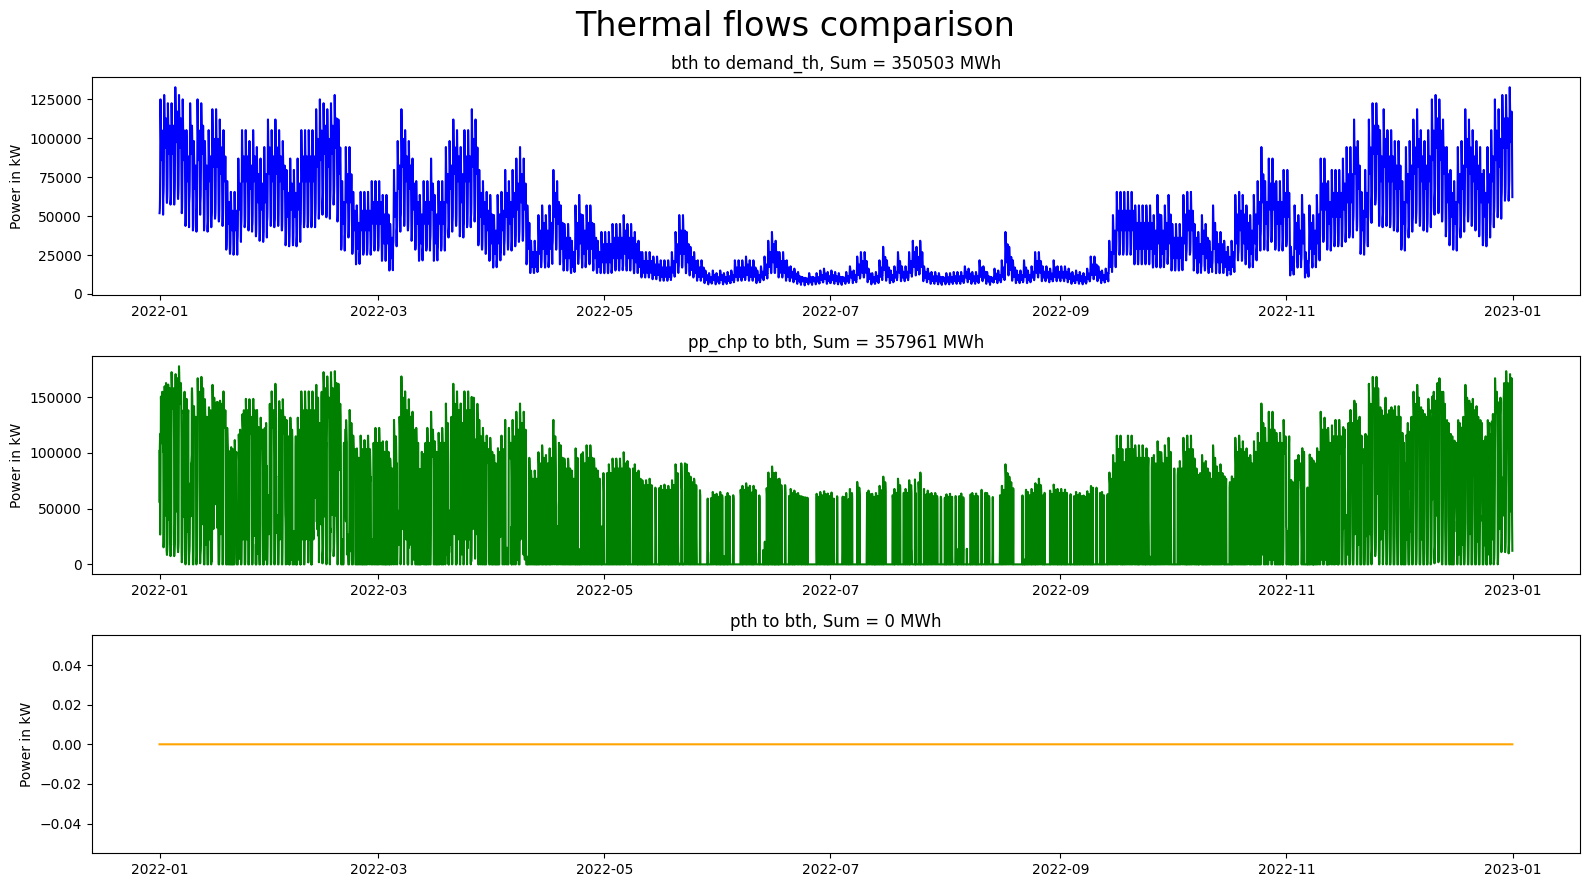

In [33]:
Sum_th_demand = thermal_bus["sequences"][(('thermal_bus', 'thermal_demand'), 'flow')].sum()
Sum_th_prod_chp = thermal_bus["sequences"][(('chp', 'thermal_bus'), 'flow')].sum()
Sum_th_prod_pth = thermal_bus["sequences"][(('electric_boiler', 'thermal_bus'), 'flow')].sum()

fig, axs = plt.subplots(3,figsize=(16, 9))
fig.suptitle('Thermal flows comparison', fontsize=24)
axs[0].plot(thermal_bus["sequences"][(('thermal_bus', 'thermal_demand'), 'flow')], 'blue')
axs[0].set_title(f'bth to demand_th, Sum = {int(Sum_th_demand/1000)} MWh')
axs[1].plot(thermal_bus["sequences"][(('chp', 'thermal_bus'), 'flow')], 'green')
axs[1].set_title(f'pp_chp to bth, Sum = {int(Sum_th_prod_chp/1000)} MWh')
axs[2].plot(thermal_bus["sequences"][(('electric_boiler', 'thermal_bus'), 'flow')], 'orange')
axs[2].set_title(f'pth to bth, Sum = {int(Sum_th_prod_pth/1000)} MWh')

axs[0].set_ylabel('Power in kW')
axs[1].set_ylabel('Power in kW')
axs[2].set_ylabel('Power in kW')

plt.tight_layout()
plt.show()

### Analyse storage node

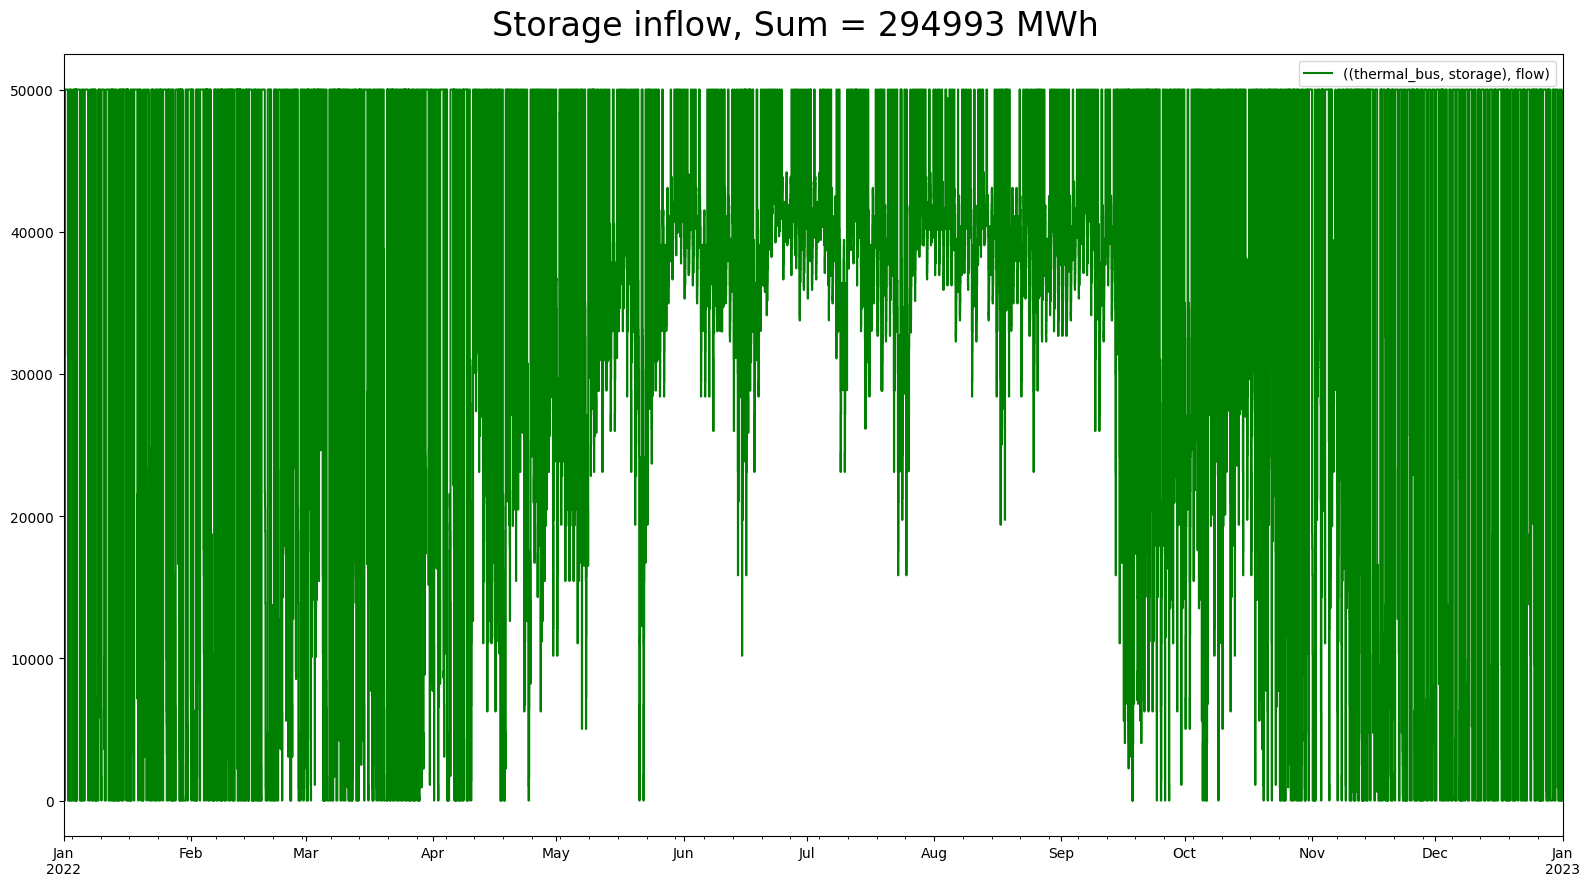

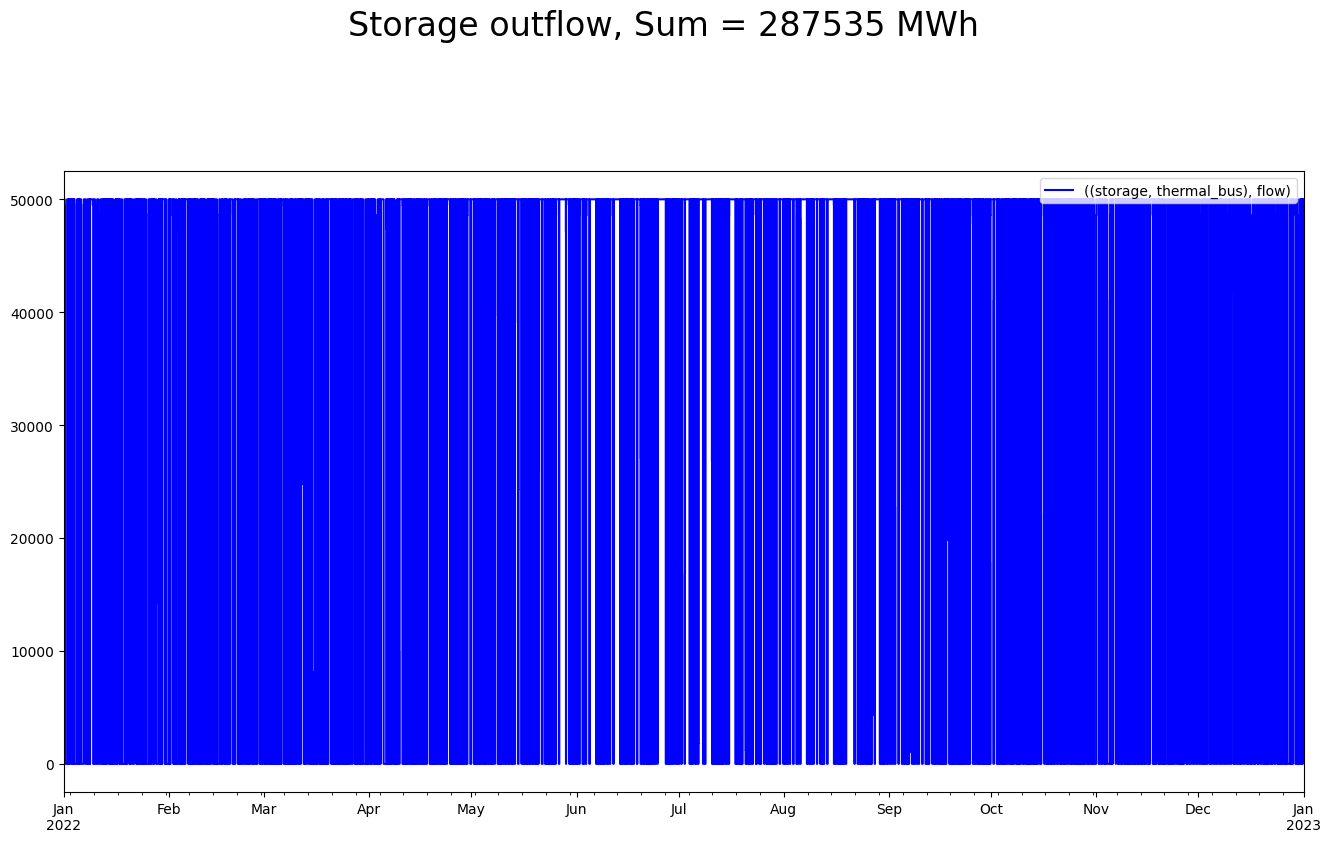

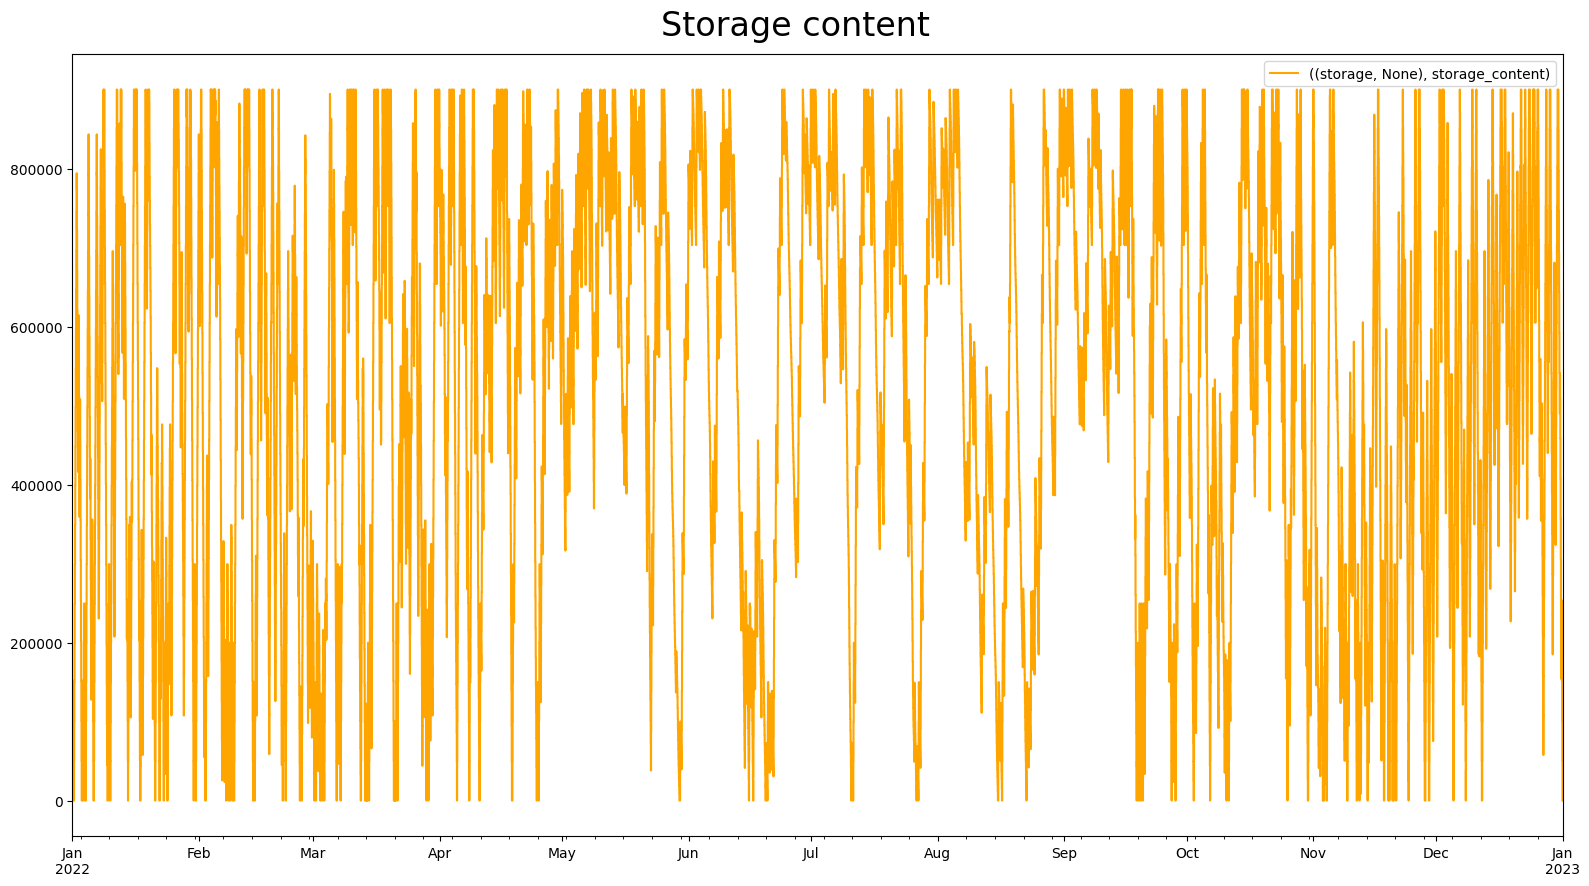

In [34]:
# Analyse storage node
Sum_storage_Outflow = storage['sequences'][(('storage', 'thermal_bus'), 'flow')].sum()
Sum_storage_Inflow = storage['sequences'][(('thermal_bus', 'storage'), 'flow')].sum()

fig, ax = plt.subplots(figsize=(16, 9))
storage['sequences'][(('thermal_bus', 'storage'), 'flow')].plot(
    ax=ax, kind="line", drawstyle="steps-post",color="green"
)
plt.legend(
    loc="upper right"
)
fig.subplots_adjust(top=0.8)
fig.suptitle(f'Storage inflow, Sum = {int(Sum_storage_Inflow / 1000)} MWh', fontsize=24)
plt.tight_layout()
plt.show()

fig, ax = plt.subplots(figsize=(16, 9))
storage['sequences'][(('storage', 'thermal_bus'), 'flow')].plot(
    ax=ax, kind="line", drawstyle="steps-post",color="blue"
)
plt.legend(
    loc="upper right"
)
fig.subplots_adjust(top=0.8)
fig.suptitle(f'Storage outflow, Sum = {int(Sum_storage_Outflow / 1000)} MWh', fontsize=24)
plt.show()

fig, ax = plt.subplots(figsize=(16, 9))
storage['sequences'][(('storage', 'None'), 'storage_content')].plot(
    ax=ax, kind="line", drawstyle="steps-post",color="orange"
)
plt.legend(
    loc="upper right"
)
fig.subplots_adjust(top=0.8)
fig.suptitle('Storage content', fontsize=24)
plt.tight_layout()
plt.show()

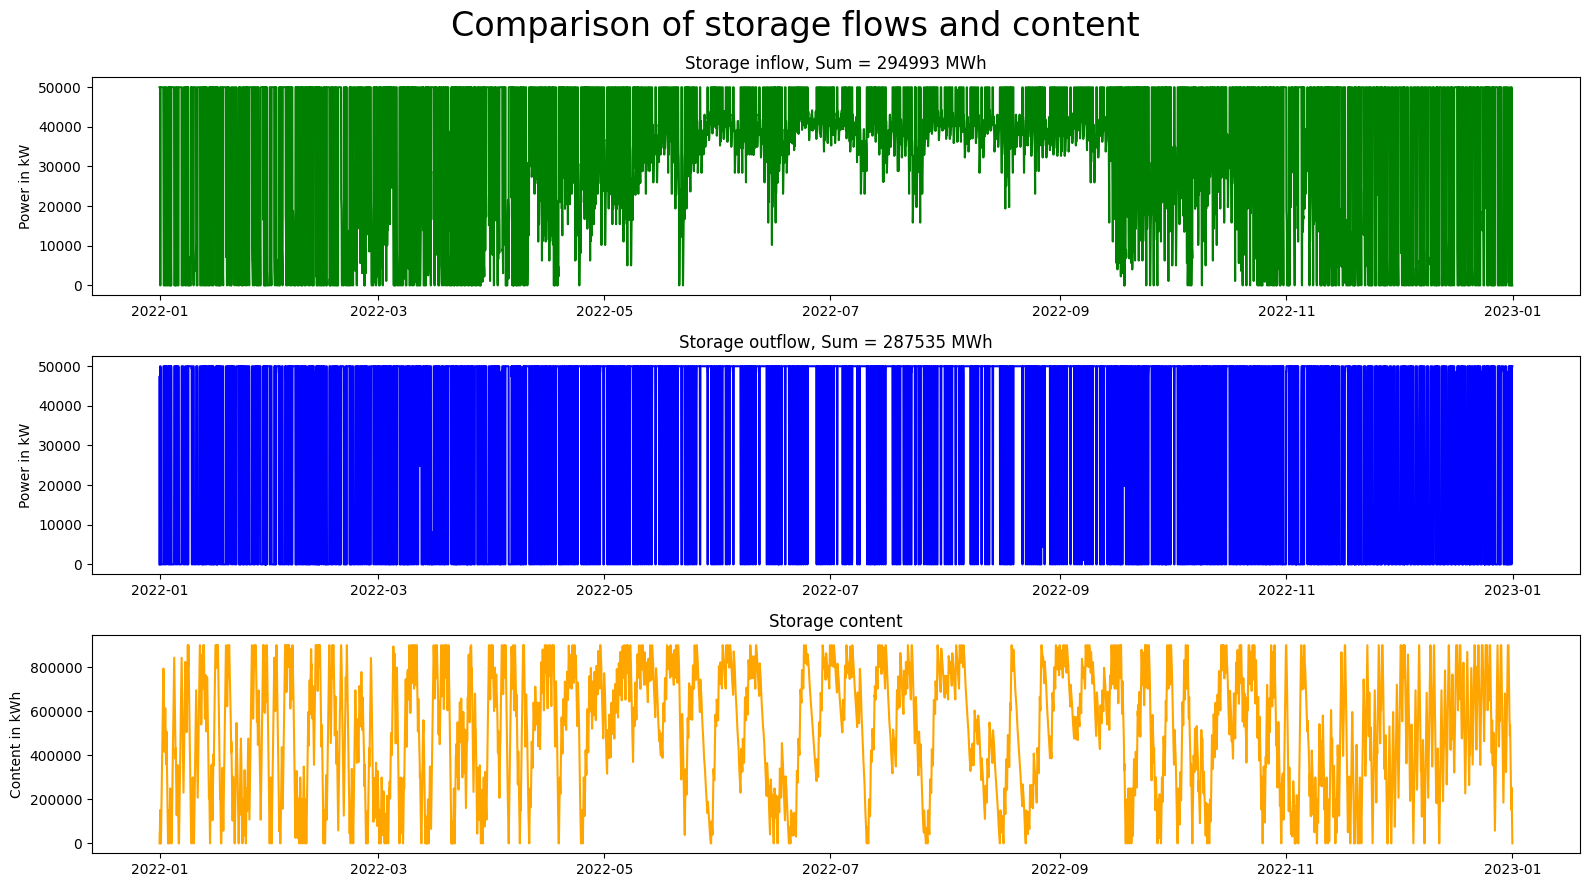

In [35]:
fig, axs = plt.subplots(3,figsize=(16, 9))
fig.suptitle('Comparison of storage flows and content', fontsize=24)
axs[0].plot(storage['sequences'][(('thermal_bus', 'storage'), 'flow')], 'green')
axs[0].set_title(f'Storage inflow, Sum = {int(Sum_storage_Inflow / 1000)} MWh')
axs[1].plot(storage['sequences'][(('storage', 'thermal_bus'), 'flow')], 'blue')
axs[1].set_title(f'Storage outflow, Sum = {int(Sum_storage_Outflow / 1000)} MWh')
axs[2].plot(storage['sequences'][(('storage', 'None'), 'storage_content')], 'orange')
axs[2].set_title('Storage content')

axs[0].set_ylabel('Power in kW')
axs[1].set_ylabel('Power in kW')
axs[2].set_ylabel('Content in kWh')

plt.tight_layout()
plt.show()